In [86]:
import numpy as np
import keras
import warnings
warnings.filterwarnings("default", category=DeprecationWarning)

In [87]:
import pandas as pd
import numpy as np
import pickle
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout

In [88]:
import nltk 
import string 
import re
def preprocess(text):
    text1 = text.lower() 
    text2 = re.sub(r'\d+', '', text1)         #remove_numbers
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space 
    text3 = text2.translate(translator)        #remove_punctuation
    return  " ".join(text3.split())             #remove_whitespace

In [89]:
#change the file DIR as per convenience
filename = '../input/train.txt'
f_train = open(filename, 'r')
filename = '../input/test.txt'
f_test = open(filename, 'r')

In [90]:
corpus_train = [preprocess(text) for text in f_train]
corpus_test = [preprocess(text) for text in f_test]

In [91]:
print("Length of train corpus = ",len(corpus_train))
print("Length of test corpus = ",len(corpus_test))

Length of train corpus =  25000
Length of test corpus =  25000


In [92]:
#target vector
targ_vec = [0] * 25000
for i in range(12500):
    targ_vec[i] = 1

In [93]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [99]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(corpus_train)
vec_train = tokenizer.texts_to_sequences(corpus_train)

In [101]:
train_vocab = tokenizer.word_index
print('Found %s unique tokens in train.' % len(train_vocab))

Found 75130 unique tokens in train.


In [102]:
X_train = pad_sequences(vec_train, maxlen=200,padding='pre') #can also try 'pre'

In [103]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(corpus_test)
vec_test = tokenizer.texts_to_sequences(corpus_test)

In [104]:
test_vocab = tokenizer.word_index
print('Found %s unique tokens in test.' % len(test_vocab))

Found 74277 unique tokens in test.


In [105]:
X_test = pad_sequences(vec_train, maxlen=200,padding='pre') #can also try 'post'

In [106]:
from keras.utils import to_categorical
labels = to_categorical(np.asarray(targ_vec))

In [107]:
#Validation data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, labels, test_size=0.2, random_state=42)

In [108]:
print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (20000, 200)
Shape of label tensor: (20000, 2)


In [111]:
#model1
from keras.layers import Embedding , SimpleRNN
model_1 = Sequential()
model_1.add(Embedding(len(train_vocab) , 128,input_length=200))
model_1.add(SimpleRNN(200, activation='tanh', return_sequences=False))
model_1.add(Dense(2, activation='sigmoid'))

In [112]:
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [113]:
print(model_1.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 128)          9616640   
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 200)               65800     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 402       
Total params: 9,682,842
Trainable params: 9,682,842
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
history = model_1.fit(x=x_train, y=y_train, batch_size=32, 
          epochs=5, verbose=1, validation_data=(x_valid , y_valid),
          shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 110s 5ms/step - loss: 0.6929 - accuracy: 0.5265 - val_loss: 0.6607 - val_accuracy: 0.5904
Epoch 2/5
20000/20000 [==============================] - 112s 6ms/step - loss: 0.6204 - accuracy: 0.6591 - val_loss: 0.6634 - val_accuracy: 0.5996
Epoch 3/5
20000/20000 [==============================] - 109s 5ms/step - loss: 0.5561 - accuracy: 0.7138 - val_loss: 0.6512 - val_accuracy: 0.6460
Epoch 4/5
20000/20000 [==============================] - 109s 5ms/step - loss: 0.5240 - accuracy: 0.7354 - val_loss: 0.6723 - val_accuracy: 0.6210
Epoch 5/5
20000/20000 [==============================] - 108s 5ms/step - loss: 0.4868 - accuracy: 0.7635 - val_loss: 0.6918 - val_accuracy: 0.6488


Text(0.5, 1.0, 'Accuracy Curves')

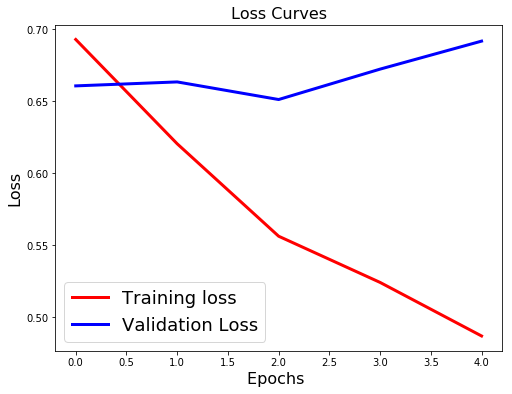

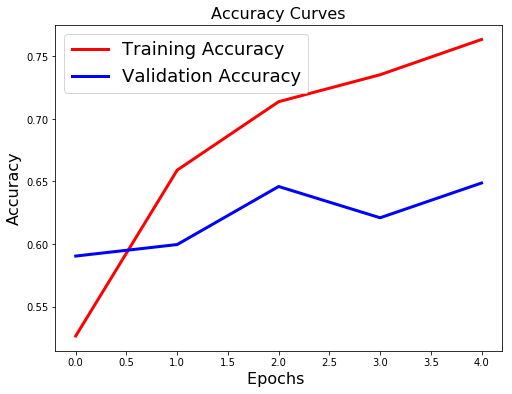

In [115]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [132]:
loss, acc = model_1.evaluate(X_test, labels, batch_size=32)
print('Test loss:', loss)
print('Test accuracy:', acc)

25000/25000 [==============================] - 61s 2ms/step
Test loss: 0.4772914975690842
Test accuracy: 0.7800400257110596


In [117]:
#model2
from keras.layers import Embedding , LSTM
model_2 = Sequential()
model_2.add(Embedding(len(train_vocab) , 128,input_length=200))
model_2.add(LSTM(200, activation='tanh', return_sequences=False))
model_2.add(Dense(2, activation='sigmoid'))

In [118]:
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [119]:
print(model_2.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 128)          9616640   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               263200    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 402       
Total params: 9,880,242
Trainable params: 9,880,242
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
history = model_2.fit(x=x_train, y=y_train, batch_size=32, 
          epochs=5, verbose=1, validation_data=(x_valid , y_valid),
          shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 158s 8ms/step - loss: 0.4954 - accuracy: 0.7650 - val_loss: 0.4672 - val_accuracy: 0.8032
Epoch 2/5
20000/20000 [==============================] - 155s 8ms/step - loss: 0.2808 - accuracy: 0.8904 - val_loss: 0.3506 - val_accuracy: 0.8600
Epoch 3/5
20000/20000 [==============================] - 153s 8ms/step - loss: 0.1508 - accuracy: 0.9464 - val_loss: 0.3640 - val_accuracy: 0.8612
Epoch 4/5
20000/20000 [==============================] - 152s 8ms/step - loss: 0.0738 - accuracy: 0.9761 - val_loss: 0.4816 - val_accuracy: 0.8456
Epoch 5/5
20000/20000 [==============================] - 154s 8ms/step - loss: 0.0622 - accuracy: 0.9799 - val_loss: 0.5452 - val_accuracy: 0.8396


Text(0.5, 1.0, 'Accuracy Curves')

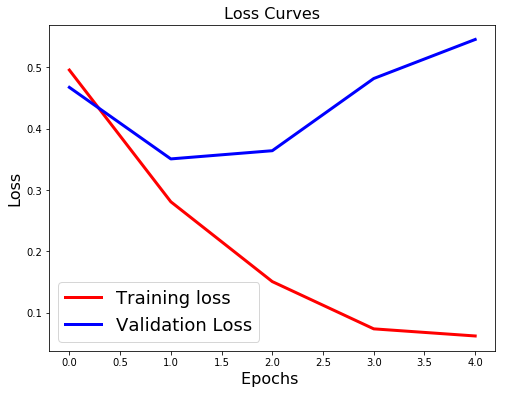

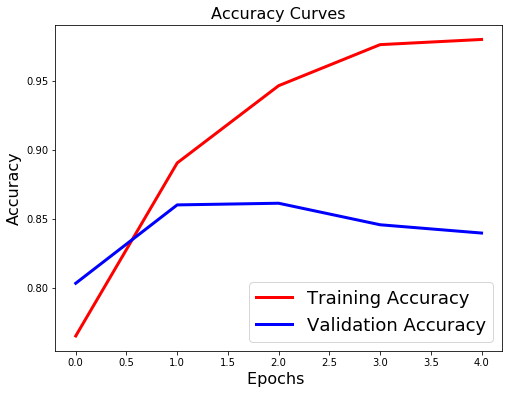

In [121]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [133]:
loss, acc = model_2.evaluate(X_test, labels, batch_size=64)
print('Test loss:', loss)
print('Test accuracy:', acc)

25000/25000 [==============================] - 35s 1ms/step
Test loss: 0.13487363067507743
Test accuracy: 0.9605600237846375


In [138]:
#model-3
from keras.layers import Embedding , GRU
model_3 = Sequential()
model_3.add(Embedding(len(train_vocab) , 128,input_length=200))
model_3.add(GRU(200, activation='tanh', return_sequences=False))
model_3.add(Dense(2, activation='sigmoid'))


model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_3.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 128)          9616640   
_________________________________________________________________
gru_7 (GRU)                  (None, 200)               197400    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 402       
Total params: 9,814,442
Trainable params: 9,814,442
Non-trainable params: 0
_________________________________________________________________
None


In [139]:
history = model_3.fit(x=x_train, y=y_train, batch_size=32, 
          epochs=5, verbose=1, validation_data=(x_valid , y_valid),
          shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 184s 9ms/step - loss: 0.4925 - accuracy: 0.7458 - val_loss: 0.3518 - val_accuracy: 0.8488
Epoch 2/5
20000/20000 [==============================] - 183s 9ms/step - loss: 0.2142 - accuracy: 0.9176 - val_loss: 0.4085 - val_accuracy: 0.8134
Epoch 3/5
20000/20000 [==============================] - 183s 9ms/step - loss: 0.0806 - accuracy: 0.9729 - val_loss: 0.4158 - val_accuracy: 0.8710
Epoch 4/5
20000/20000 [==============================] - 188s 9ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.5528 - val_accuracy: 0.8692
Epoch 5/5
20000/20000 [==============================] - 182s 9ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.6403 - val_accuracy: 0.8542


Text(0.5, 1.0, 'Accuracy Curves')

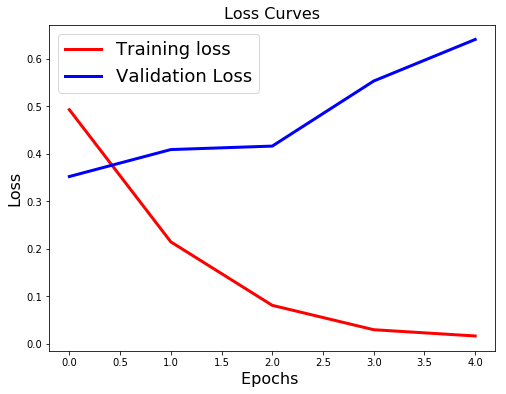

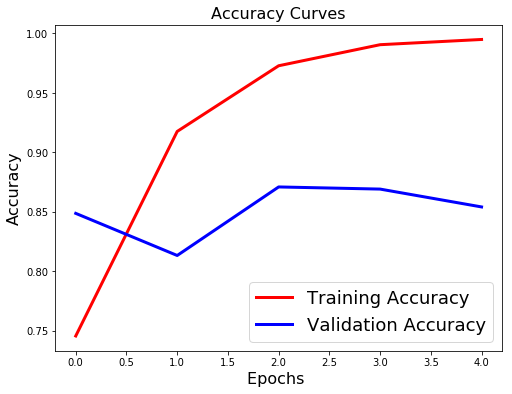

In [140]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [141]:
loss, acc = model_3.evaluate(X_test, labels, batch_size=32)
print('Test score:', loss)
print('Test accuracy:', acc)

25000/25000 [==============================] - 84s 3ms/step
Test score: 0.1315251394584123
Test accuracy: 0.9701200127601624


### The LSTM and GRU are very close to each other. See the stats:
*  RNN:<br>
    &emsp; valid_acc : 0.6488<br>
    &emsp; val_loss : 0.6918<br>
    &emsp; Test_acc : 0.7800 <br>
    &emsp; Test_loss : 0.4773<br>
* LSTM:<br>
    &emsp; valid_acc : 0.8396<br>
    &emsp; val_loss : 0.5452<br>
    &emsp; Test_acc : 0.9605<br>
    &emsp; Test_loss : 0.1348<br>
* GRU:<br>
    &emsp; valid_acc : 0.8542<br>
    &emsp; val_loss : 0.6403<br>
    &emsp; Test_acc : 0.9701<br>
    &emsp; Test_loss : 0.1315<br>
### But GRU have little edge over LSTM , So moving with GRU

In [142]:
#model-4
model_4 = Sequential()
model_4.add(Embedding(len(train_vocab) , 128,input_length=200))
model_4.add(GRU(200, activation='tanh', return_sequences=True))
model_4.add(GRU(200, activation='tanh', return_sequences=False))
model_4.add(Dense(2, activation='sigmoid'))


model_4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_4.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 128)          9616640   
_________________________________________________________________
gru_8 (GRU)                  (None, 200, 200)          197400    
_________________________________________________________________
gru_9 (GRU)                  (None, 200)               240600    
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 402       
Total params: 10,055,042
Trainable params: 10,055,042
Non-trainable params: 0
_________________________________________________________________
None


In [143]:
history = model_4.fit(x=x_train, y=y_train, batch_size=32, 
          epochs=5, verbose=1, validation_data=(x_valid , y_valid),
          shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 361s 18ms/step - loss: 0.5193 - accuracy: 0.7442 - val_loss: 0.3992 - val_accuracy: 0.8238
Epoch 2/5
20000/20000 [==============================] - 362s 18ms/step - loss: 0.2406 - accuracy: 0.9054 - val_loss: 0.2976 - val_accuracy: 0.8816
Epoch 3/5
20000/20000 [==============================] - 362s 18ms/step - loss: 0.0899 - accuracy: 0.9694 - val_loss: 0.3563 - val_accuracy: 0.8604
Epoch 4/5
20000/20000 [==============================] - 363s 18ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.5279 - val_accuracy: 0.8544
Epoch 5/5
  480/20000 [..............................] - ETA: 5:26 - loss: 0.0296 - accuracy: 0.9896

KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy Curves')

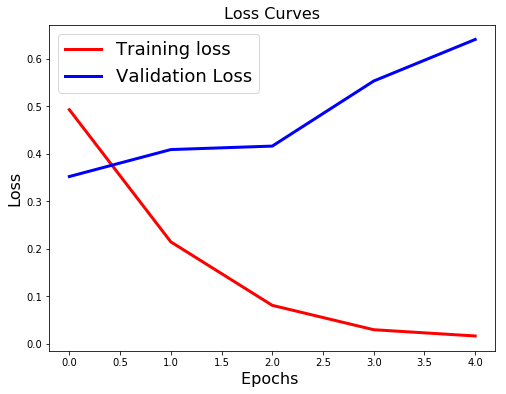

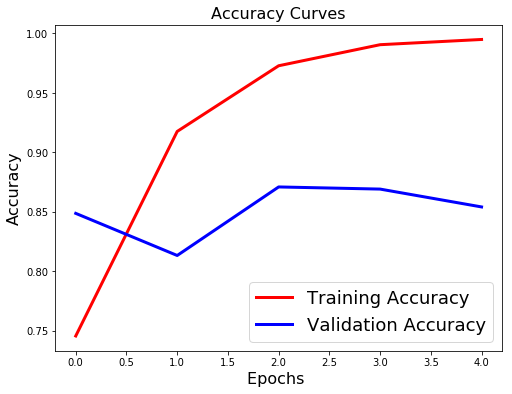

In [144]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [145]:
score, acc = model_4.evaluate(X_test, labels, batch_size=32)
print('Test loss:', score)
print('Test accuracy:', acc)

25000/25000 [==============================] - 157s 6ms/step
Test loss: 0.10754388427495956
Test accuracy: 0.9691600203514099


In [148]:
#model-5
model_5 = Sequential()
model_5.add(Embedding(len(train_vocab) , 128,input_length=200))
model_5.add(GRU(200, activation='tanh', return_sequences=True))
model_5.add(GRU(200, activation='tanh', return_sequences=True))
model_5.add(GRU(200, activation='tanh', return_sequences=False))
model_5.add(Dense(2, activation='sigmoid'))


model_5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model_5.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 200, 128)          9616640   
_________________________________________________________________
gru_10 (GRU)                 (None, 200, 200)          197400    
_________________________________________________________________
gru_11 (GRU)                 (None, 200, 200)          240600    
_________________________________________________________________
gru_12 (GRU)                 (None, 200)               240600    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 402       
Total params: 10,295,642
Trainable params: 10,295,642
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model_5.fit(x=x_train, y=y_train, batch_size=32, 
          epochs=1, verbose=1, validation_data=(x_valid , y_valid),
          shuffle=True)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/1
 8096/20000 [===========>..................] - ETA: 4:57 - loss: 0.5850 - accuracy: 0.6818

In [ ]:
import matplotlib.pyplot as plt
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
score, acc = model_5.evaluate(X_test, labels, batch_size=32)
print('Test loss:', score)
print('Test accuracy:', acc)

[Click here to get table](https://docs.google.com/document/d/1ONLiPCFF_62i8hzuhz9TH3Tx1WWBXpahkSwTcrOlN6M/edit?usp=sharing)